## Setup

In [1]:
#@markdown Select whether you would like to use Google Drive.
#@markdown
#@markdown If you select **Yes**, you will need to authorize Colab to access
#@markdown your personal drive.
#@markdown
#@markdown If you select to use Google Drive, you can select to save the figures generated.
USE_GDRIVE = 'Yes' #@param ["Yes", "No"]
SAVE_FIGS = 'No' #@param ["Yes", "No"]
SAVE_FIGS = True if SAVE_FIGS == "Yes" else False
if USE_GDRIVE == "No":
  ![ -d cnn_txf_bias ] || git clone https://github.com/shikhartuli/cnn_txf_bias.git
  %cd cnn_txf_bias
else:
  # ! pip install SciencePlots
  # ! sudo apt-get install texlive-latex-recommended 
  # ! sudo apt install texlive-latex-extra
  # ! sudo apt install dvipng
  # ! sudo apt install cm-super
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
import scipy.stats
import itertools
import os

plt.style.reload_library()
js_dist_class_exp = {}
js_dist_inter_exp = {}
js_vs_cohen_exp = {}

categories_CIFAR = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

acc_im = {}
acc_im['ViT-B/32'] = eval(pd.read_csv(f'./vision_transformer/results/fine-tune/cifar10/vit_fine-tune.csv')['CIFAR-10 Accuracy'][0][:-1])/100
acc_im['ViT-B/32(ft.)'] = eval(pd.read_csv(f'vision_transformer/results/fine-tune/cifar10/vit_fine-tune.csv')['CIFAR-10 Accuracy'][6][:-1])/100
acc_im['ResNet-50'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/cifar10/bit_fine-tune.csv')['CIFAR-10 Accuracy'][0][:-1])/100
acc_im['ResNet-50(ft.)'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/cifar10/bit_fine-tune.csv')['CIFAR-10 Accuracy'][6][:-1])/100
acc_im['AlexNet'] = 0.8967
acc_im['VGG-16'] = 0.9342
acc_im['GoogleNet'] = 0.8691
# Source:- https://github.com/danhdoan/cifar10-end2end-mxnet

print(f'CIFAR-10 accuracies: {acc_im}')

%cd "cifar-10h/"

CIFAR-10 accuracies: {'ViT-B/32': 0.9729000000000001, 'ViT-B/32(ft.)': 0.9737, 'ResNet-50': 0.9390999999999999, 'ResNet-50(ft.)': 0.8801000000000001, 'AlexNet': 0.8967, 'VGG-16': 0.9342, 'GoogleNet': 0.8691}
/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/cifar-10h


In [68]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Define colors

In [4]:
colors_models = {'ViT-B/32': '#F1C40F', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50(ft.)': '#296389', 'ResNet-50': '#4292C6', 'AlexNet': '#916946', 'GoogleNet': '#B4A096', 'VGG-16': '#238b45'}
colors_scatter_ft = {'ViT-B/32': '#E67E22', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50(ft.)': '#296389'}

## Experiments on CIFAR-10H


In [5]:
experiment = 'cifar-10h'

### Define distance metric

In [6]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate Human confusion matrices

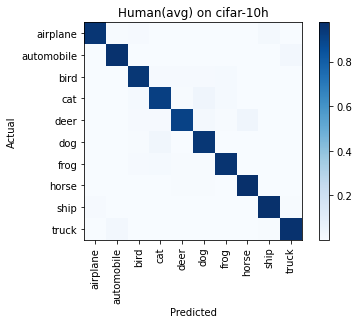

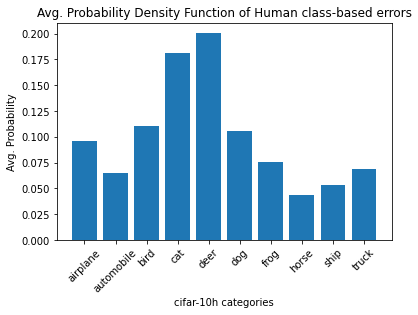

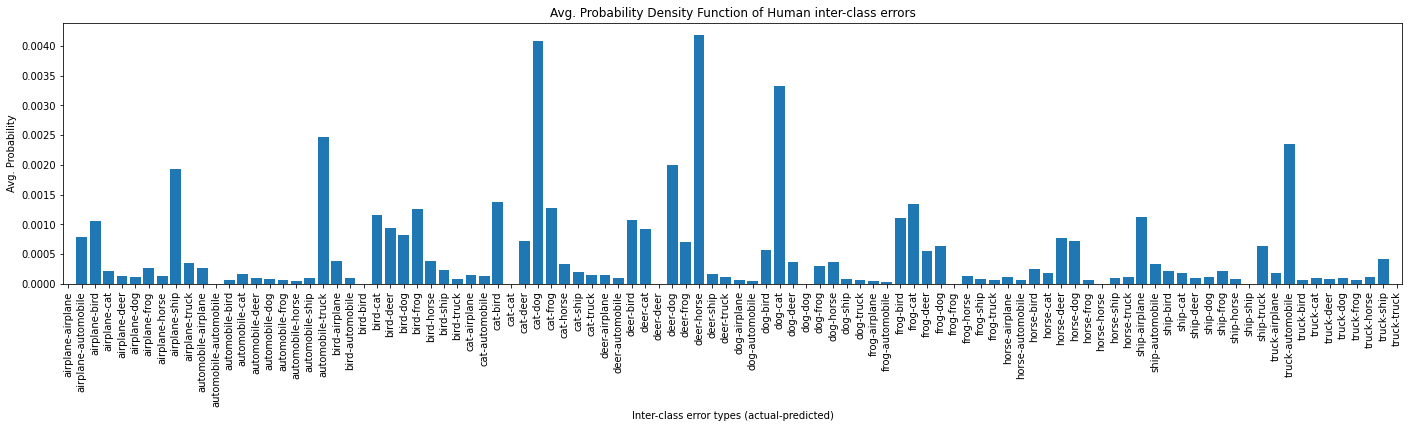

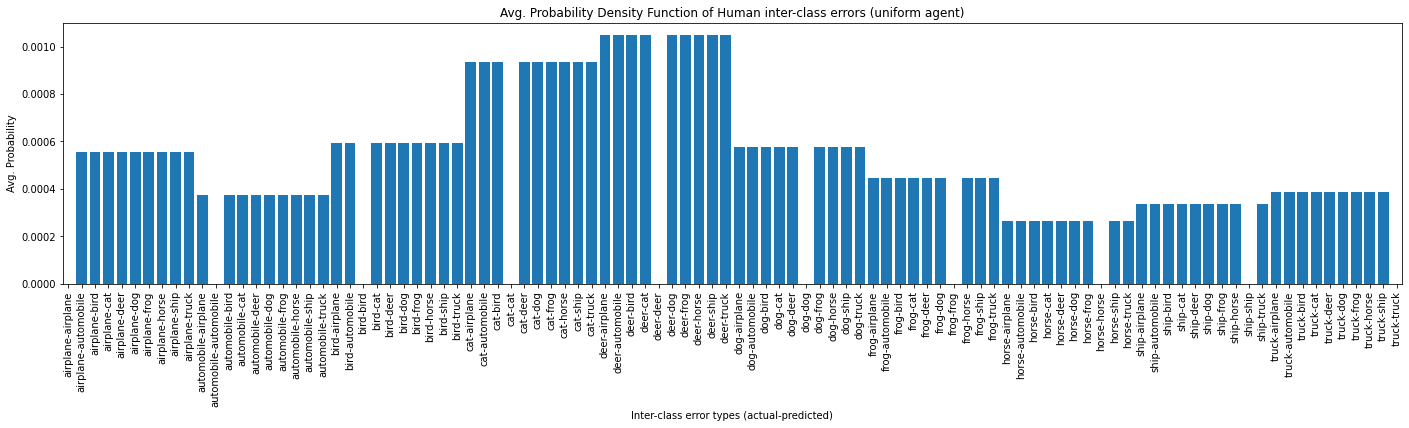

In [46]:
class_pdf_list = []
uniform_inter_pdf_list = []
inter_pdf_list = []
# uniform_weighted_inter_pdf_list = []
# weighted_inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

human_csv = pd.read_csv(f'./cifar10h-raw.csv')
num_subjects = len(list(set(human_csv['annotator_id'])))
considered_subjects = num_subjects

for i in range(len(categories_CIFAR)):
  misclassification_human[categories_CIFAR[i]] = 0

for sub in range(num_subjects):

  sub_idx = np.where(human_csv['annotator_id'] == sub)[0]
  pred = human_csv['chosen_category'][sub_idx]
  true = human_csv['true_category'][sub_idx]

  cm = confusion_matrix(true, pred, labels = categories_CIFAR)
  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  if np.all(cm_errors == 0): 
    considered_subjects -= 1
    continue

  cm_norm = confusion_matrix(true, pred, labels = categories_CIFAR, normalize = 'true')

  cm_norm_list.append(cm_norm)

  for i in range(len(categories_CIFAR)):
    misclassification_human[categories_CIFAR[i]] += cm_errors[i, [j for j in range(len(categories_CIFAR)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)

  # inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_errors = np.divide(cm, np.sum(cm))
  np.fill_diagonal(inter_pdf_errors, 0)
  inter_pdf_errors = inter_pdf_errors.reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(10):
    class_mean = np.sum(inter_pdf_errors[i*10:(i+1)*10])/9
    test_class_pdf = [class_mean for _ in range(10)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*10:(i+1)*10] = test_class_pdf

  uniform_inter_pdf_list.append(uniform_inter_pdf_errors)

  # # Weighing errors by ConceptNet distance
  # weighted_inter_pdf_errors = np.divide(cm*MULT*conceptnet_cm, np.sum(cm*MULT*conceptnet_cm))
  # np.fill_diagonal(weighted_inter_pdf_errors, 0)
  # weighted_inter_pdf_errors = weighted_inter_pdf_errors.reshape(-1)
  # weighted_inter_pdf_list.append(weighted_inter_pdf_errors)

  # uniform_weighted_inter_pdf_errors = np.copy(weighted_inter_pdf_errors)
  # for i in range(10):
  #   class_mean = np.sum(weighted_inter_pdf_errors[i*10:(i+1)*10])/9
  #   test_class_pdf = [class_mean for _ in range(10)]
  #   test_class_pdf[i] = 0
  #   uniform_weighted_inter_pdf_errors[i*10:(i+1)*10] = test_class_pdf

  # uniform_weighted_inter_pdf_list.append(uniform_weighted_inter_pdf_errors)

  # full_pdf = np.divide(cm, np.sum(cm)).reshape(-1)
  # full_pdf_list.append(full_pdf)

  # uniform_full_pdf = np.copy(full_pdf)
  # for i in range(16):
  #   class_mean = (np.sum(full_pdf[i*16:(i+1)*16]) - full_pdf[16*i + i])/15
  #   test_class_pdf = [class_mean for _ in range(16)]
  #   test_class_pdf[i] = full_pdf[16*i + i]
  #   uniform_full_pdf[i*16:(i+1)*16] = test_class_pdf

  # uniform_full_pdf_list.append(uniform_full_pdf)

  # Commenting plots
  # fig, ax = plt.subplots()
  # plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  # plt.title(f'Human_{sub} on {experiment}')
  # plt.colorbar()
  # ax.set_xticks(np.arange(10))
  # ax.set_yticks(np.arange(10))
  # ax.set_xticklabels(categories_CIFAR, rotation=90)
  # ax.set_yticklabels(categories_CIFAR)
  # ax.set_xlabel('Predicted')
  # ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
uniform_inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(considered_subjects):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
  inter_pdf_avg += inter_pdf_list[i]
  uniform_inter_pdf_avg += uniform_inter_pdf_list[i]
class_pdf_avg = np.divide(class_pdf_avg, considered_subjects)
cm_norm_avg = np.divide(cm_norm_avg, considered_subjects)
inter_pdf_avg = np.divide(inter_pdf_avg, considered_subjects)
uniform_inter_pdf_avg = np.divide(uniform_inter_pdf_avg, considered_subjects)

for i in range(len(categories_CIFAR)):
  misclassification_human[categories_CIFAR[i]] = np.divide(misclassification_human[categories_CIFAR[i]], considered_subjects)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

human_class_pdf_list = class_pdf_list
human_inter_pdf_list = inter_pdf_list
human_uniform_inter_pdf_list = uniform_inter_pdf_list

# human_weighted_inter_pdf_list = weighted_inter_pdf_list
# human_uniform_weighted_inter_pdf_list = uniform_weighted_inter_pdf_list

# human_full_pdf_list = full_pdf_list
# human_uniform_full_pdf_list = uniform_full_pdf_list

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(categories_CIFAR, rotation=90)
ax.set_yticklabels(categories_CIFAR)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_CIFAR, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[24, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_CIFAR, categories_CIFAR)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

fig = plt.figure(figsize=[24, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_CIFAR, categories_CIFAR)], uniform_inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors (uniform agent)')
plt.margins(x=0,tight=True)
plt.show()


In [47]:
num_subjects, considered_subjects

(2571, 2570)

### Generate ViT confusion matrices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


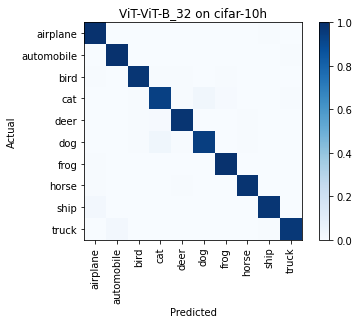

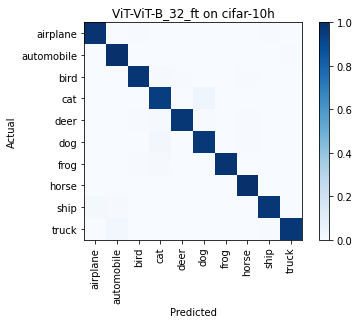

In [69]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = {'ViT-B_32': 'ViT-B/32', 'ViT-B_32_ft': 'ViT-B/32(ft.)'}

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}
js_dist_inter_uniform = {}
js_dist_weighted = {}
js_dist_weighted_uniform = {}
# js_dist_full = {}
# js_dist_full_uniform = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./{model}.csv')
  pred = vit_csv['chosen_category']
  true = vit_csv['true_category']

  cm = confusion_matrix(true, pred, labels = categories_CIFAR)
  cm_norm = confusion_matrix(true, pred, labels = categories_CIFAR, normalize = 'true')

  cm_norm_dict[vit_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_CIFAR)):
    misclassification_error[categories_CIFAR[i]] = cm_errors[i, [j for j in range(len(categories_CIFAR)) if j != i]]

  mse_misclassification[vit_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_CIFAR}
  # js_misclassification[vit_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_CIFAR}

  js_misclassification[vit_models[model]] = {}
  for i in range(len(categories_CIFAR)):
    js_misclassification[vit_models[model]][categories_CIFAR[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  # inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_errors = np.divide(cm, np.sum(cm))
  np.fill_diagonal(inter_pdf_errors, 0)
  inter_pdf_errors = inter_pdf_errors.reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(10):
    class_mean = np.sum(inter_pdf_errors[i*10:(i+1)*10])/9
    test_class_pdf = [class_mean for _ in range(10)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*10:(i+1)*10] = test_class_pdf

  # # Weighing errors by ConceptNet distance
  # weighted_inter_pdf_errors = np.divide(cm*MULT*conceptnet_cm, np.sum(cm*MULT*conceptnet_cm))
  # np.fill_diagonal(weighted_inter_pdf_errors, 0)
  # weighted_inter_pdf_errors = weighted_inter_pdf_errors.reshape(-1)

  # uniform_weighted_inter_pdf_errors = np.copy(weighted_inter_pdf_errors)
  # for i in range(16):
  #   class_mean = np.sum(weighted_inter_pdf_errors[i*16:(i+1)*16])/15
  #   test_class_pdf = [class_mean for _ in range(16)]
  #   test_class_pdf[i] = 0
  #   uniform_weighted_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  # full_pdf = np.divide(cm, np.sum(cm)).reshape(-1)

  # uniform_full_pdf = np.copy(full_pdf)
  # for i in range(16):
  #   class_mean = (np.sum(full_pdf[i*16:(i+1)*16]) - full_pdf[16*i + i])/15
  #   test_class_pdf = [class_mean for _ in range(16)]
  #   test_class_pdf[i] = full_pdf[16*i + i]
  #   uniform_full_pdf[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[vit_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[vit_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[vit_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[vit_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[vit_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[vit_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  # js_dist_weighted[vit_models[model]] = mean_confidence_interval([js_distance(weighted_inter_pdf_errors, human_w) for human_w in human_weighted_inter_pdf_list])
  # js_dist_weighted_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_weighted_inter_pdf_errors, human_w_uni) for human_w_uni in human_uniform_weighted_inter_pdf_list])
  
  # js_dist_full[vit_models[model]] = mean_confidence_interval([js_distance(full_pdf, human_full) for human_full in human_full_pdf_list])
  # js_dist_full_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_full_pdf, human_full_uni) for human_full_uni in human_uniform_full_pdf_list])

  acc_exp[vit_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(10))
  ax.set_yticks(np.arange(10))
  ax.set_xticklabels(categories_CIFAR, rotation=90)
  ax.set_yticklabels(categories_CIFAR)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate CNN confusion matrices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


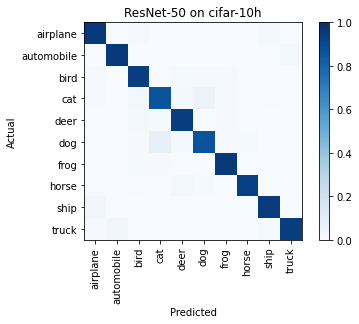

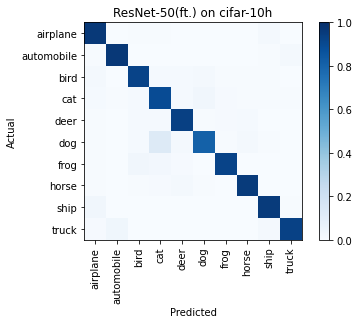

In [70]:
# conv_models = {'resnet50': 'ResNet-50', 'resnet50_ft': 'ResNet-50(ft.)', 'alexnet': 'AlexNet', 'vgg16-bn': 'VGG-16', 'inception-v3': 'GoogleNet'}
conv_models = {'resnet50': 'ResNet-50', 'resnet50_ft': 'ResNet-50(ft.)'}
all_models = vit_models.copy()
all_models.update(conv_models)

for model in conv_models:
  resnet_csv = pd.read_csv(f'./{model}.csv')
  pred = resnet_csv['chosen_category']
  true = resnet_csv['true_category']

  cm = confusion_matrix(true, pred, labels = categories_CIFAR)
  cm_norm = confusion_matrix(true, pred, labels = categories_CIFAR, normalize = 'true')

  cm_norm_dict[conv_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_CIFAR)):
    misclassification_error[categories_CIFAR[i]] = cm_errors[i, [j for j in range(len(categories_CIFAR)) if j != i]]

  mse_misclassification[conv_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_CIFAR}
  # js_misclassification[conv_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_CIFAR}

  js_misclassification[conv_models[model]] = {}
  for i in range(len(categories_CIFAR)):
    js_misclassification[conv_models[model]][categories_CIFAR[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  # inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_errors = np.divide(cm, np.sum(cm))
  np.fill_diagonal(inter_pdf_errors, 0)
  inter_pdf_errors = inter_pdf_errors.reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(10):
    class_mean = np.sum(inter_pdf_errors[i*10:(i+1)*10])/9
    test_class_pdf = [class_mean for _ in range(10)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*10:(i+1)*10] = test_class_pdf

  # # Weighing errors by ConceptNet distance
  # weighted_inter_pdf_errors = np.divide(cm*MULT*conceptnet_cm, np.sum(cm*MULT*conceptnet_cm))
  # np.fill_diagonal(weighted_inter_pdf_errors, 0)
  # weighted_inter_pdf_errors = weighted_inter_pdf_errors.reshape(-1)

  # uniform_weighted_inter_pdf_errors = np.copy(weighted_inter_pdf_errors)
  # for i in range(16):
  #   class_mean = np.sum(weighted_inter_pdf_errors[i*16:(i+1)*16])/15
  #   test_class_pdf = [class_mean for _ in range(16)]
  #   test_class_pdf[i] = 0
  #   uniform_weighted_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  # full_pdf = np.divide(cm, np.sum(cm)).reshape(-1)

  # uniform_full_pdf = np.copy(full_pdf)
  # for i in range(16):
  #   class_mean = (np.sum(full_pdf[i*16:(i+1)*16]) - full_pdf[16*i + i])/15
  #   test_class_pdf = [class_mean for _ in range(16)]
  #   test_class_pdf[i] = full_pdf[16*i + i]
  #   uniform_full_pdf[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[conv_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[conv_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[conv_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[conv_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[conv_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[conv_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])
  
  # js_dist_weighted[conv_models[model]] = mean_confidence_interval([js_distance(weighted_inter_pdf_errors, human_w) for human_w in human_weighted_inter_pdf_list])
  # js_dist_weighted_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_weighted_inter_pdf_errors, human_w_uni) for human_w_uni in human_uniform_weighted_inter_pdf_list])

  # js_dist_full[conv_models[model]] = mean_confidence_interval([js_distance(full_pdf, human_full) for human_full in human_full_pdf_list])
  # js_dist_full_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_full_pdf, human_full_uni) for human_full_uni in human_uniform_full_pdf_list])

  acc_exp[conv_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'{conv_models[model]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(10))
  ax.set_yticks(np.arange(10))
  ax.set_xticklabels(categories_CIFAR, rotation=90)
  ax.set_yticklabels(categories_CIFAR)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B/32, 	 KL-Distance: 0.108
Model: ViT-B/32(ft.), 	 KL-Distance: 0.101
Model: ResNet-50, 	 KL-Distance: 0.185
Model: ResNet-50(ft.), 	 KL-Distance: 0.224
Model: AlexNet, 	 KL-Distance: 0.153
Model: VGG-16, 	 KL-Distance: 0.216
Model: GoogleNet, 	 KL-Distance: 0.122


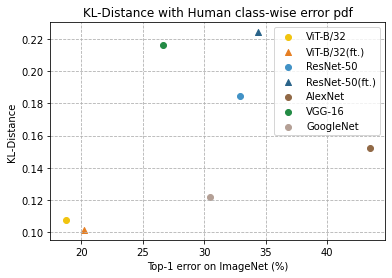

In [ ]:
PLOT_IMAGENET_ACC = True

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B/32, 	 KL-Distance: 1.170
Model: ViT-B/32(ft.), 	 KL-Distance: 1.106
Model: ResNet-50, 	 KL-Distance: 0.789
Model: ResNet-50(ft.), 	 KL-Distance: 1.145
Model: AlexNet, 	 KL-Distance: 0.647
Model: VGG-16, 	 KL-Distance: 0.581
Model: GoogleNet, 	 KL-Distance: 0.640


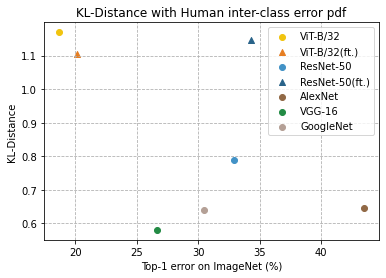

In [ ]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot JS distance (class-wise) with CIFAR-10 accuracy

Model: ViT-B/32, 	 JS-Distance: 0.473
Model: ViT-B/32(ft.), 	 JS-Distance: 0.451
Model: ResNet-50, 	 JS-Distance: 0.460
Model: ResNet-50(ft.), 	 JS-Distance: 0.467


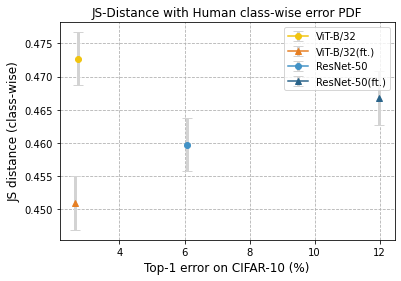

In [71]:
js_dist_class_exp[experiment] = js_dist_class

for model in js_dist_class.keys():
  plt.errorbar((1-acc_im[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel(f'Top-1 error on CIFAR-10 (%)', fontsize=12)
plt.ylabel('JS distance (class-wise)', fontsize=12)
# plt.ylim([0.16, 0.28])
plt.legend(loc='upper right')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_imagenet_class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human class-wise error PDF')
plt.show()

### Plot JS distance (inter-class) with CIFAR-10 accuracy


Model: ViT-B/32, 	 JS-Distance: 0.666
Model: ViT-B/32(ft.), 	 JS-Distance: 0.652
Model: ResNet-50, 	 JS-Distance: 0.663
Model: ResNet-50(ft.), 	 JS-Distance: 0.673


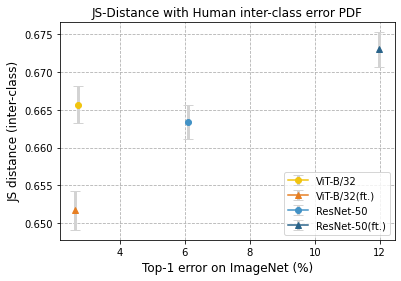

In [72]:
js_dist_inter_exp[experiment] = js_dist_inter

for model in js_dist_inter.keys():
  plt.errorbar((1-acc_im[model])*100, js_dist_inter[model][0], js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel(f'Top-1 error on CIFAR-10 (%)', fontsize=12)
plt.ylabel('JS distance (inter-class)', fontsize=12)
plt.legend(loc='lower right')
# plt.ylim([0.52, 0.68])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_imagenet_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human inter-class error PDF')
plt.show()

### Plot JS distance (class-wise) with experiment accuracy


Model: ViT-B/32, 	 JS-Distance: 0.191
Model: ViT-B/32(ft.), 	 JS-Distance: 0.187
Model: ResNet-50, 	 JS-Distance: 0.227
Model: ResNet-50(ft.), 	 JS-Distance: 0.245
Model: AlexNet, 	 JS-Distance: 0.215
Model: VGG-16, 	 JS-Distance: 0.240
Model: GoogleNet, 	 JS-Distance: 0.199


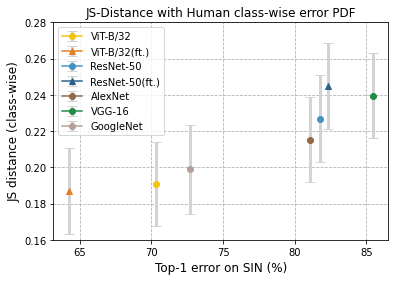

In [ ]:
for model in js_dist_class.keys():
  plt.errorbar((1-acc_exp[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}')

plt.grid(linestyle='--')
exp = 'SIN' if experiment.endswith('conflict') else experiment.capitalize()
plt.xlabel(f'Top-1 error on {exp} (%)', fontsize=12)
plt.ylabel('JS distance (class-wise)', fontsize=12)
plt.ylim([0.16, 0.28])
plt.legend(loc='upper left')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_exp_class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human class-wise error PDF')
plt.show()

### Plot JS distance (inter-class) with experiment accuracy


Model: ViT-B/32, 	 JS-Distance: 0.627
Model: ViT-B/32(ft.), 	 JS-Distance: 0.620
Model: ResNet-50, 	 JS-Distance: 0.578
Model: ResNet-50(ft.), 	 JS-Distance: 0.638
Model: AlexNet, 	 JS-Distance: 0.573
Model: VGG-16, 	 JS-Distance: 0.553
Model: GoogleNet, 	 JS-Distance: 0.562


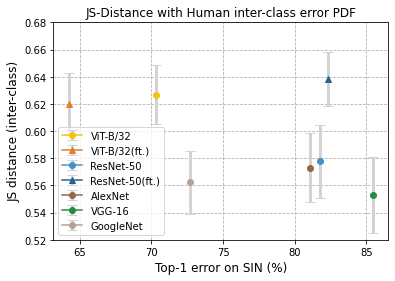

In [ ]:
for model in js_dist_inter.keys():
  plt.errorbar((1-acc_exp[model])*100, js_dist_inter[model][0], js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model][0]:0.3f}')

plt.grid(linestyle='--')
exp = 'SIN' if experiment.endswith('conflict') else experiment.capitalize()
plt.xlabel(f'Top-1 error on {exp} (%)', fontsize=12)
plt.ylabel('JS distance (inter-class)', fontsize=12)
plt.legend(loc='lower left')
plt.ylim([0.52, 0.68])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_exp_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human inter-class error PDF')
plt.show()

### Plot JS distance (class-wise) with ImageNet and experiment accuracy


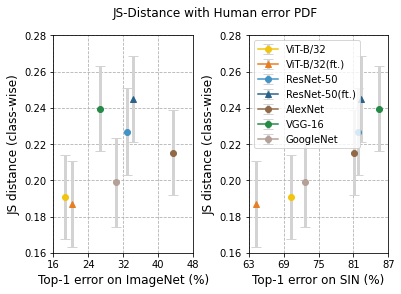

In [ ]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace = 0.4)

for model in js_dist_class.keys():
  ax[0].errorbar((1-acc_im[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  ax[1].errorbar((1-acc_exp[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')

ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
exp = 'SIN' if experiment.endswith('conflict') else experiment.capitalize()
ax[0].set_xlabel('Top-1 error on ImageNet (%)', fontsize=12)
ax[0].set_ylabel('JS distance (class-wise)', fontsize=12)
ax[1].set_xlabel(f'Top-1 error on {exp} (%)', fontsize=12)
ax[1].set_ylabel('JS distance (class-wise)', fontsize=12)
ax[1].set_xlim([63, 87])
ax[1].set_xticks([63, 69, 75, 81, 87])
# ax[0].set_xticks(np.linspace(ax[0].get_xticks()[0], ax[0].get_xticks()[-1], len(ax[1].get_xticks())))
ax[0].set_xlim([16, 48])
ax[0].set_xticks([16, 24, 32, 40, 48])
ax[0].set_ylim([0.16, 0.28])
ax[1].set_ylim([0.16, 0.28])
plt.legend(loc='upper left')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_im&exp_class_{experiment}.pdf', bbox_inches = 'tight')
plt.suptitle('JS-Distance with Human error PDF')
plt.show()

### Plot JS distance between misclassifications per class

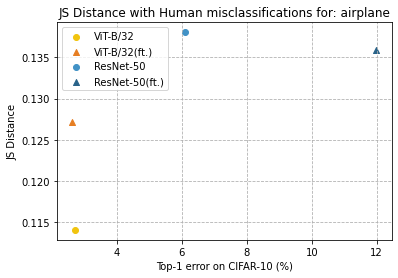

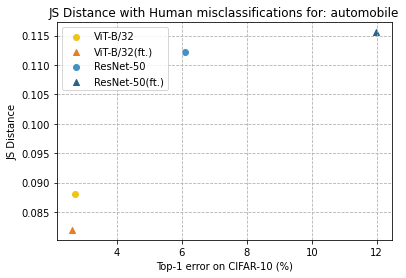

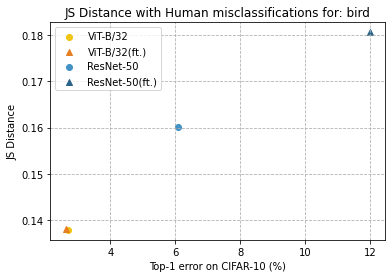

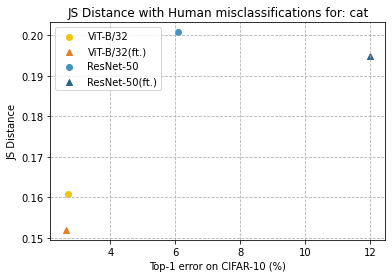

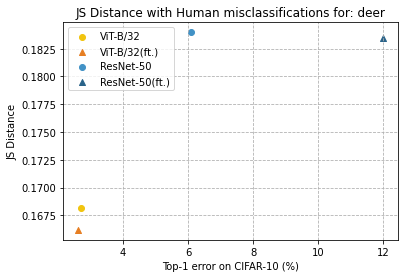

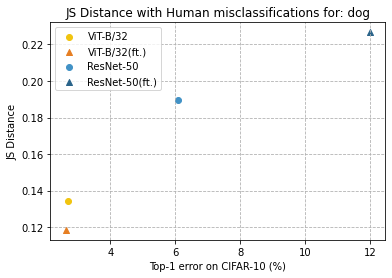

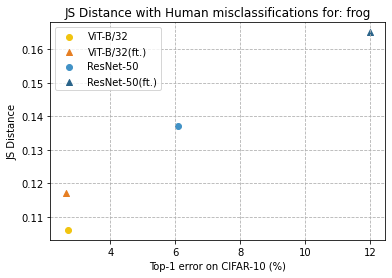

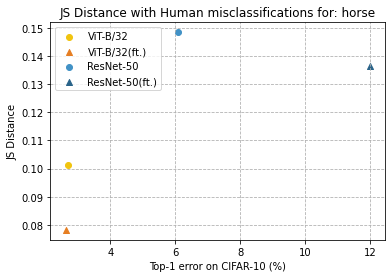

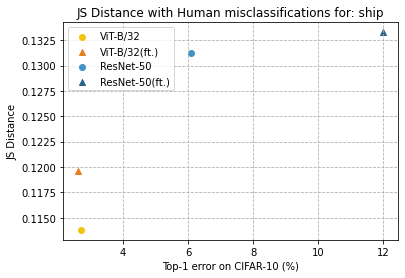

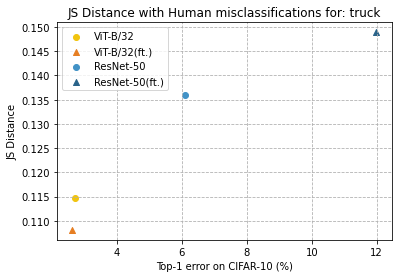

In [73]:
PLOT_IMAGENET_ACC = True

for category in categories_CIFAR:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  
  plt.grid(linestyle='--')
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on CIFAR-10 (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

Model: ViT-B/32, mean JS distance: 0.12387190907828556
Model: ViT-B/32(ft.), mean JS distance: 0.12069892703130272
Model: ResNet-50, mean JS distance: 0.15375497279084124
Model: ResNet-50(ft.), mean JS distance: 0.16209791906450466


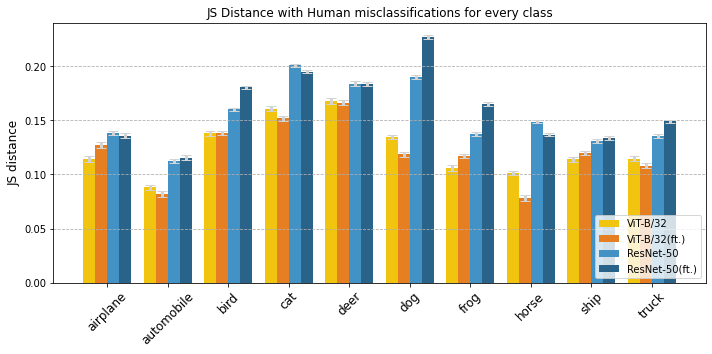

In [74]:
x = np.arange(len(categories_CIFAR))
width = 0.2

fig, ax = plt.subplots(figsize=[10, 4.8])

count = 0
for model in js_misclassification.keys():
  if not (model.startswith('ViT') or model.startswith('ResNet')): continue
  ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_CIFAR], width, label=model, color=colors_models[model])
  ax.errorbar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_CIFAR], fmt='none', yerr=[js_misclassification[model][cat][1] for cat in categories_CIFAR], capsize=5, ecolor='lightgray', elinewidth=3)
  print(f'Model: {model}, mean JS distance: {np.mean([js_misclassification[model][cat][0] for cat in categories_CIFAR])}')
  count += 1

ax.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_CIFAR, fontsize=12)
ax.legend(loc='lower right')
# ax.set_ylim([0, 0.8])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_misclassifications_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('JS Distance with Human misclassifications for every class')
plt.show()

### Plot JS (class-wise) with Cohen's Kappa

Model: ViT-B/32, 	 JS-Distance: 0.191, 	 Cohen's Kappa: 0.137
Model: ViT-B/32(ft.), 	 JS-Distance: 0.187, 	 Cohen's Kappa: 0.156
Model: ResNet-50, 	 JS-Distance: 0.227, 	 Cohen's Kappa: 0.068
Model: ResNet-50(ft.), 	 JS-Distance: 0.245, 	 Cohen's Kappa: 0.030
Model: AlexNet, 	 JS-Distance: 0.215, 	 Cohen's Kappa: 0.080
Model: VGG-16, 	 JS-Distance: 0.240, 	 Cohen's Kappa: 0.042
Model: GoogleNet, 	 JS-Distance: 0.199, 	 Cohen's Kappa: 0.120


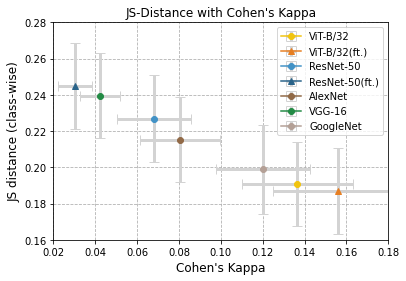

In [ ]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

for model in js_dist_class.keys():
  plt.errorbar(cohens_k[model][0], js_dist_class[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  # plt.scatter(cohens_k[model][0], js_dist_class[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel('Cohen\'s Kappa', fontsize=12)
plt.ylabel('JS distance (class-wise)', fontsize=12)
plt.legend()
plt.xlim([0.02, 0.18])
plt.ylim([0.16, 0.28])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot JS (inter-class) with Cohen's Kappa

Model: ViT-B/32, 	 JS-Distance: 0.191, 	 Cohen's Kappa: 0.137
Model: ViT-B/32(ft.), 	 JS-Distance: 0.187, 	 Cohen's Kappa: 0.156
Model: ResNet-50, 	 JS-Distance: 0.227, 	 Cohen's Kappa: 0.068
Model: ResNet-50(ft.), 	 JS-Distance: 0.245, 	 Cohen's Kappa: 0.030
Model: AlexNet, 	 JS-Distance: 0.215, 	 Cohen's Kappa: 0.080
Model: VGG-16, 	 JS-Distance: 0.240, 	 Cohen's Kappa: 0.042
Model: GoogleNet, 	 JS-Distance: 0.199, 	 Cohen's Kappa: 0.120


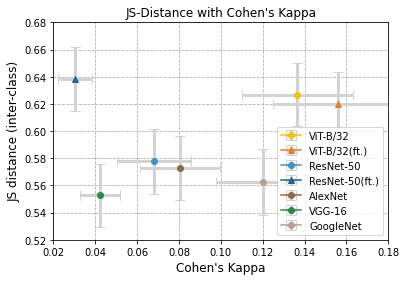

In [ ]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

for model in js_dist_class.keys():
  plt.errorbar(cohens_k[model][0], js_dist_inter[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  # plt.scatter(cohens_k[model][0], js_dist_class[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel('Cohen\'s Kappa', fontsize=12)
plt.ylabel('JS distance (inter-class)', fontsize=12)
plt.legend()
plt.xlim([0.02, 0.18])
plt.ylim([0.52, 0.68])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot JS (class-wise and inter-class) with Cohen's Kappa

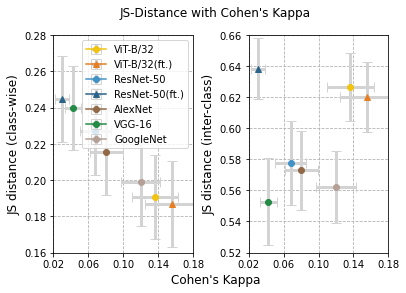

In [ ]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

fig, ax = plt.subplots(1, 2, sharex=True)
plt.subplots_adjust(wspace = 0.4)
# fig.tight_layout()

for model in js_dist_class.keys():
  ax[0].errorbar(cohens_k[model][0], js_dist_class[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  ax[1].errorbar(cohens_k[model][0], js_dist_inter[model][0], xerr=cohens_k[model][1], yerr=js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')

ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
fig.text(0.5, 0.02, 'Cohen\'s Kappa', fontsize=12, ha='center')
ax[0].set_ylabel('JS distance (class-wise)', fontsize=12)
ax[1].set_ylabel('JS distance (inter-class)', fontsize=12)
ax[0].legend(loc='upper right')
ax[0].set_xlim([0.02, 0.18])
plt.xticks([0.02, 0.06, 0.10, 0.14, 0.18])
ax[0].set_ylim([0.16, 0.28])
ax[1].set_ylim([0.52, 0.66])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_class&inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.suptitle('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot all metrics (all models)



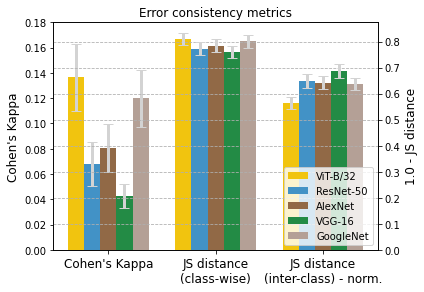

In [ ]:
metrics = ['Cohen\'s Kappa', 'JS distance\n(class-wise)', 'JS distance\n(inter-class) - norm.']
# metrics = ['Cohen\'s Kappa', 'JS distance\n(class-wise)', 'JS distance\n(inter-class) - norm.', 'JS distance\n(full) - norm.']
# metrics = ['Cohen\'s Kappa', 'JS distance\n(class-wise)', 'JS distance\n(full) - norm.']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots() #figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if model.endswith('(ft.)'): continue
  ax.bar(x[0] - 4*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 4*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  # ax2.bar(x[1:] - 4*width/2 + width*count, [1- js_dist_class[model][0], 1 - (js_dist_weighted[model][0])], width, label=model, color=colors_models[model])
  # ax2.errorbar(x[1:] - 4*width/2 + width*count, [1 - js_dist_class[model][0], 1 - (js_dist_weighted[model][0])], yerr=[js_dist_class[model][1], js_dist_weighted[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 4*width/2 + width*count, [1- js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 4*width/2 + width*count, [1 - js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], yerr=[js_dist_class[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  # ax2.bar(x[1:] - 4*width/2 + width*count, [1- js_dist_class[model][0], 1 - (js_dist_full[model][0] - js_dist_full_uniform[model][0])], width, label=model, color=colors_models[model])
  # ax2.errorbar(x[1:] - 4*width/2 + width*count, [1 - js_dist_class[model][0], 1 - (js_dist_full[model][0] - js_dist_full_uniform[model][0])], yerr=[js_dist_class[model][1], js_dist_full[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

# plt.rcParams.update({"text.usetex": True})
ax.set_ylabel("Cohen's Kappa", fontsize=12)
ax2.set_ylabel('1.0 - JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.18])
# ax2.set_ylim([0, 0.9])
ax2.legend(loc='lower right')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

### Plot all metrics (fine-tuning)



In [ ]:
metrics = ['Cohen\'s Kappa', 'JS distance\n(class-wise)', 'JS distance\n(inter-class) - norm.']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots() #figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if (model.startswith('VGG') or model.startswith('Alex') or model.startswith('Google')): continue
  ax.bar(x[0] - 3*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 3*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 3*width/2 + width*count, [1- js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 3*width/2 + width*count, [1 - js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], yerr=[js_dist_class[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

# plt.rcParams.update({"text.usetex": True})
ax.set_ylabel("Cohen's Kappa", fontsize=12)
ax2.set_ylabel('1.0- JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.18])
# ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))
ax2.set_ylim([0, 0.9])
ax2.legend(loc='lower right')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}_ft.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

### Plot JS (class-wise and inter-class) with ft.



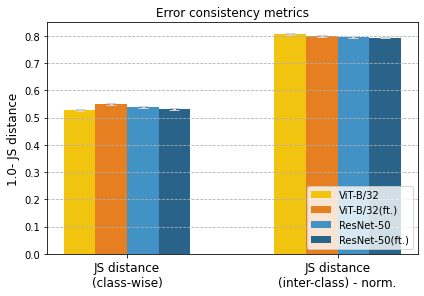

In [75]:
metrics = ['JS distance\n(class-wise)', 'JS distance\n(inter-class) - norm.']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots() #figsize=[12, 4.8])

count = 0
for model in all_models.values():
  if (model.startswith('VGG') or model.startswith('Alex') or model.startswith('Google')): continue
  ax.bar(x - 3*width/2 + width*count, [1- js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], width, label=model, color=colors_models[model])
  ax.errorbar(x - 3*width/2 + width*count, [1 - js_dist_class[model][0], 1 - (js_dist_inter[model][0] - js_dist_inter_uniform[model][0])], yerr=[js_dist_class[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

# plt.rcParams.update({"text.usetex": True})
# ax.set_ylabel("Cohen's Kappa", fontsize=12)
ax.set_ylabel('1.0- JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
# ax.set_ylim([0, 0.18])
# ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))
# ax2.set_ylim([0, 0.9])
ax.legend(loc='lower right')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}_ft.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()